# Example of an EoR0 sky simulation using OSKAR

In this example we take an arbitrary sky and use karabo to simulate the visibilities. We simulate the visibilites once using OSKAR and image with wsclean.

In [1]:
import math
import os
import shutil
from datetime import datetime, timedelta, timezone
import numpy as np

# these have to go before importing karabo
os.environ["TMPDIR"] = "/cygnus/tmp"
%env TMPDIR=/cygnus/tmp

from karabo.data.obscore import ObsCoreMeta
from karabo.data.src import RucioMeta
from karabo.imaging.image import Image
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.telescope_versions import SKALowAAStarVersions, SKALowAA1Versions
from karabo.simulation.visibility import Visibility
from karabo.simulator_backend import SimulatorBackend
from karabo.util.helpers import get_rnd_str


# Simulation
# Phase center: should be mean of coverage
# Means of values from sky model description
PHASE_CENTER_RA = 1.0
PHASE_CENTER_DEC = -27.0

# Imaging
IMAGING_NPIXEL = 8000
IMAGING_CELLSIZE = 0.00006 # can't tell if radians or degrees

# Metadata
NAME_PREFIX = "skalow_eor_"

# Output root dir, this is just a default, set to your liking
OUTPUT_ROOT_DIR = os.path.join("/cygnus", f"{NAME_PREFIX}output")
os.makedirs(OUTPUT_ROOT_DIR, exist_ok=True)
print(f"Output will be written under output root dir {OUTPUT_ROOT_DIR}")

# 1 timestep, 375 channels starting from 170 MHz to 200 MHz, 80kHz wide
# Wavelength 185MHz = 1.62 m
number_of_time_steps = 1
start_frequency_hz = 170e6
# end_frequency_hz = 200e6
frequency_increment_hz = 80e3
end_frequency_hz = start_frequency_hz + 3 * frequency_increment_hz
number_of_channels = math.floor(
    (end_frequency_hz - start_frequency_hz) / frequency_increment_hz
)

os.environ["TMPDIR"] = "/cygnus/tmp"

%matplotlib inline
%env TMPDIR=/cygnus/tmp

env: TMPDIR=/cygnus/tmp


Output will be written under output root dir /cygnus/skalow_eor_output
env: TMPDIR=/cygnus/tmp


## Sky Model : GLEAM

num_sources=1
right ascension (deg),declination (deg),stokes I Flux (Jy),stokes Q Flux (Jy),stokes U Flux (Jy),stokes V Flux (Jy),reference_frequency (Hz),spectral index (N/A),rotation measure (rad / m^2),major axis FWHM (arcsec),minor axis FWHM (arcsec),position angle (deg),true redshift,observed redshift,source id (object)
1.0,-27.0,100.0,0.0,0.0,0.0,150000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


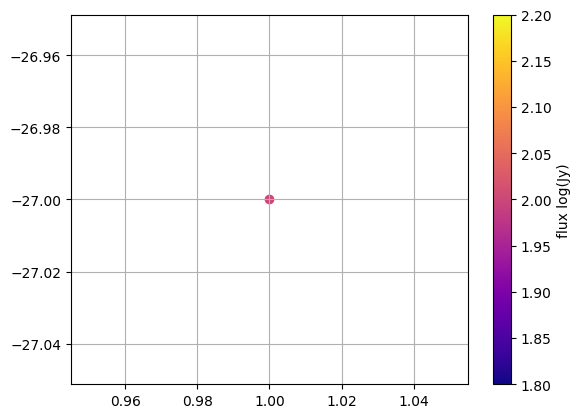

In [2]:
sky_model = SkyModel()
sky_model.add_point_sources(np.array([[
    PHASE_CENTER_RA, # RA
    PHASE_CENTER_DEC, # Dec
    100.0, # stokes I Flux (Jy),
    0.0, # stokes Q Flux (Jy),
    0.0, # stokes U Flux (Jy),
    0.0, # stokes V Flux (Jy),
    150e6, # reference_frequency (Hz),
    0.0, # spectral index (N/A),
    0.0, # rotation measure (rad / m^2),
    0.0, # major axis FWHM (arcsec),
    0.0, # minor axis FWHM (arcsec),
    0.0, # position angle (deg),
    0.0, # true redshift,
    0.0, # observed redshift,
    0, # source id (object)
]]))
# sky_model = SkyModel.get_GLEAM_Sky(min_freq=start_frequency_hz, max_freq=end_frequency_hz)\
#     .filter_by_flux(min_flux_jy=0.005, max_flux_jy=100000)\
#     .filter_by_radius(ra0_deg=PHASE_CENTER_RA, dec0_deg=PHASE_CENTER_DEC, inner_radius_deg=0, outer_radius_deg=90)

print(f"num_sources={len(sky_model.sources)}")
sky_model.save_sky_model_as_csv('/dev/stdout')

sky_model.explore_sky(
    phase_center=(PHASE_CENTER_RA, PHASE_CENTER_DEC),
    wcs_enabled=False,
)

limited sourcelist filtering.
would be nice to filter by beam used in InterferometerSimulation (next section)

## Telescope Model SKA Low AAstar

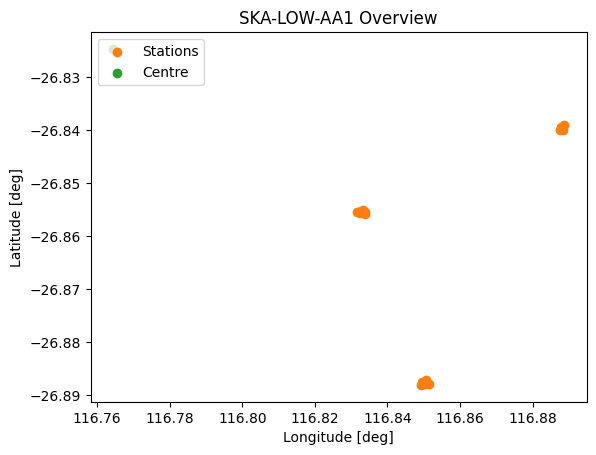

In [3]:
simulator_backend = SimulatorBackend.OSKAR

telescope = Telescope.constructor(  # type: ignore[call-overload]
    name="SKA-LOW-AA1",
    version=SKALowAA1Versions.SKA_OST_ARRAY_CONFIG_2_3_1,
    backend=simulator_backend,
)

telescope.plot_telescope()

## Run Simulation

In [4]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=frequency_increment_hz,
    # station_type="Aperture array",
    station_type="Isotropic beam",
    use_gpus=True,
)

observation = Observation(
    phase_centre_ra_deg=PHASE_CENTER_RA,
    phase_centre_dec_deg=PHASE_CENTER_DEC,
    start_date_and_time=datetime(2000, 1, 1, 5, 30, 0, 0, timezone.utc),
    length=timedelta(seconds=number_of_time_steps * 7.997),
    number_of_time_steps=number_of_time_steps,
    number_of_channels=number_of_channels,
    start_frequency_hz=start_frequency_hz,
    frequency_increment_hz=frequency_increment_hz,
)

sim_start = datetime.now()
print(f"{sim_start} starting simulation number_of_channels={number_of_channels} number_of_time_steps={number_of_time_steps}")

vis_out_path = os.path.join(
    OUTPUT_ROOT_DIR,
    f"{NAME_PREFIX}.MS",
)
# delete existing visibility file if it exists
if os.path.exists(vis_out_path):
    os.system(f"rm -rf {vis_out_path}")

visibilities = simulation.run_simulation(  # type: ignore[no-any-return]
    telescope,
    sky_model,
    observation,
    backend=simulator_backend,
    visibility_path=vis_out_path,
)  # type: ignore[call-overload]

sim_end = datetime.now()
print(f"{sim_end} simulation completed: {sim_end - sim_start}")

2025-09-02 08:13:03.370433 starting simulation number_of_channels=3 number_of_time_steps=1
Matched path /cygnus/skalow_eor_output/skalow_eor_.MS to format MS
Saved visibility to /cygnus/skalow_eor_output/skalow_eor_.MS
2025-09-02 08:13:03.798442 simulation completed: 0:00:00.428009


## Vis Metadata

In [5]:
ocm = ObsCoreMeta.from_visibility(
    vis=visibilities,
    calibrated=False,
)
print(ocm)

Error reading /cygnus/skalow_eor_output/skalow_eor_.MS with pyuvdata version 2.4.1: list index out of range - patching broken pyuvdata history check


ObsCoreMeta(dataproduct_type='visibility', dataproduct_subtype=None, calib_level=1, obs_collection=None, obs_id=None, obs_publisher_did=None, obs_title=None, obs_creator_did=None, target_class=None, access_url=None, access_format=None, access_estsize=367, target_name=None, s_ra=1.0, s_dec=-27.0, s_fov=None, s_region=None, s_resolution=62.628705834308526, s_xel1=None, s_xel2=None, s_pixel_scale=None, t_min=51544.229207175784, t_max=51544.229207175784, t_exptime=nan, t_resolution=nan, t_xel=1, em_min=1.7614127967097533, em_max=1.763900082372323, em_res_power=2126.0, em_xel=3, em_ucd='em.energy;em.radio', o_ucd='phot.flux.density;phys.polarisation', pol_states='/YY/YX/XX/XY/', pol_xel=4, facility_name=None, instrument_name='OSKAR 2.8.3')


Mean of empty slice.
invalid value encountered in scalar divide


In [10]:
from casacore.tables import table
tb = table(vis_out_path)
print("first baseline, first pol")
display(tb.getcol("DATA")[0,...,0].tolist())
print("last baseline, last pol")
display(tb.getcol("DATA")[-1,...,-1].tolist())

Successful readonly open of default-locked table /cygnus/skalow_eor_output/skalow_eor_.MS: 22 columns, 120 rows
first baseline, first pol


[(100.00000762939453-0.00047995001659728587j),
 (100.00000762939453-0.000480184011394158j),
 (100.00000762939453-0.00048040333786047995j)]

last baseline, last pol


[(100+0.00012755861098412424j),
 (100+0.00012761764810420573j),
 (100+0.00012767294538207352j)]

## Imaging

Creating /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-dirty-KqpjmH9FeP for Disk cache for WSClean dirty images
WSClean command: [cd /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-dirty-KqpjmH9FeP && OPENBLAS_NUM_THREADS=1 wsclean -size 8000 8000 -scale 0.0034377467707849396deg /cygnus/skalow_eor_output/skalow_eor_.MS]
WSClean output:
[
WSClean version 3.5 (2024-07-30)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  170-170 (3)
Precalculating weights for uniform weighting...
Opening /cygnus/skalow_eor_output/skalow_eor_.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-120; 120 rows)
 == Constructing image ==
Detected 503.7 GB of system memory, usage not limited.
Opening /cygnus/skalow_eor_output/skalow_eo

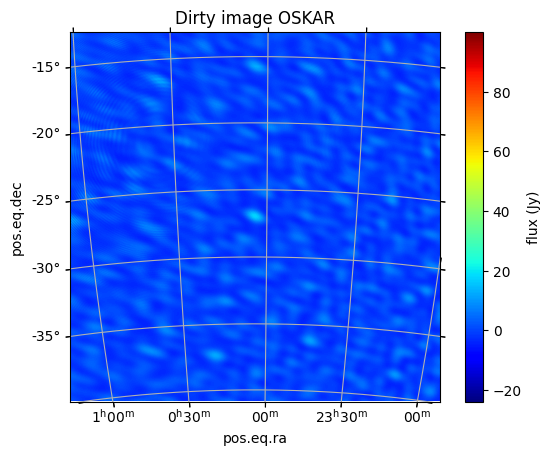

In [12]:
dirty_imager = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=IMAGING_NPIXEL,
        imaging_cellsize=IMAGING_CELLSIZE,
        combine_across_frequencies=True,
    )
)

dirty_image = dirty_imager.create_dirty_image(
    visibilities,
    output_fits_path=os.path.join(
        OUTPUT_ROOT_DIR,
        f"{NAME_PREFIX}dirty.fits",
    ),
)

dirty_image.plot(
    title="Dirty image OSKAR",
    # vmin=0, vmax=1.0
)


In [ ]:
# image_cleaner = WscleanImageCleaner(
#     WscleanImageCleanerConfig(
#         imaging_npixel=IMAGING_NPIXEL,
#         imaging_cellsize=IMAGING_CELLSIZE,
#     )
# )

# clean_image = image_cleaner.create_cleaned_image(
#     visibilities,
#     # dirty_fits_path=dirty_image.path,
#     output_fits_path=os.path.join(
#         OUTPUT_ROOT_DIR,
#         f"{NAME_PREFIX}cleaned.fits",
#     ),
# )

# clean_image.plot(
#     title="Clean image OSKAR + WSClean",
#     # vmin=0, vmax=1.0
# )